# Chapter 3 : 傾向スコアを利用した効果の推定
## Agenda

- propensity score matchingを用いた効果推定手法の紹介

## REMARKS

- causal treeのパッケージ精度は未検証
- cobalt再現の箇所で0.25にdashed line付与
- sndの関数作成

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [2]:
!python -V

Python 3.7.4


### Install packages

In [3]:
#!pip install causal_tree_learn

### Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.iolib.summary2 import summary_col
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
#from CTL.causal_tree_learn import CausalTree

### 自作関数のimport

In [5]:
#import homemade_causaltree as hct

### `../ch_02_ols`より自作関数をimport

In [6]:
import sys
sys.path.append('..')
sys.path.append('../ch_02_ols')

In [7]:
from ch_02_ols import propensity_score_matching as psmatch

## 1. Propensity scoreとnearest matching

テキストp100で紹介されている`matchit`をPythonで実装する。

- `matchit`のnearest matchingはwith replacement method
- psの推定はdafaultではlogit
- Pythonではsklearnを用いて実装する

### Data

In [8]:
def bias(s):
    """ Return Biased weighting
    
    Calculate the sample weighting based on recency, channel and treatment
    
    Args:
        s:data
        
    Returns:
        sample weight
    """
    loyal = s['history'] > 300 or s['recency'] < 3 or s['channel'] == 'Multichannel'
    if (s['treatment'] == 1 and not loyal) or (s['treatment'] == 0 and loyal):
        return 0.5
    else:
        return 1.0

In [9]:
df = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.loc[:, 'treatment'] = df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = df.loc[df['segment'] != 'Womens E-Mail']
male_df = male_df.reset_index(drop = True)
biased_df = male_df.sample(frac=0.5, weights=male_df.apply(bias, axis=1), random_state=42)

In [10]:
biased_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
15973,6,2) $100 - $200,148.25,1,0,Urban,0,Phone,Mens E-Mail,0,0,0.0,1
40542,3,3) $200 - $350,309.67,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1
31254,7,2) $100 - $200,140.80,0,1,Urban,0,Web,No E-Mail,0,0,0.0,0
25571,10,1) $0 - $100,29.99,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0,0
6640,6,2) $100 - $200,111.25,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1


### Propensity Scoreの推定

In [11]:
logit_formula = 'treatment ~ recency + history + channel'
logit_res = smf.logit(formula=logit_formula, data=biased_df).fit()
propensity_score = logit_res.predict()
biased_df['p_logit'] = propensity_score

Optimization terminated successfully.
         Current function value: 0.677751
         Iterations 5


### Plot

''

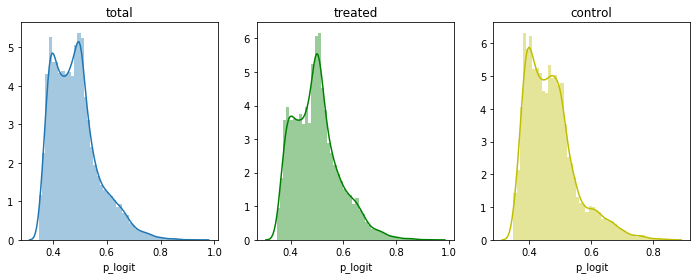

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
is_treat = biased_df['treatment'] == 1
sns.distplot(biased_df['p_logit'], ax  = ax[0])
sns.distplot(biased_df.loc[is_treat,'p_logit'], ax  = ax[1], color = 'g')
sns.distplot(biased_df.loc[~is_treat,'p_logit'], ax  = ax[2], color = 'y')

ax[0].set_title('total')
ax[1].set_title('treated')
ax[2].set_title('control')
;

### Nearest Matching with replacement

In [13]:
treated_df = biased_df.loc[is_treat,:].reset_index(drop = True)
non_treated_df = biased_df.loc[~is_treat,:].reset_index(drop = True)

In [14]:
### Estimate ATT
treated = treated_df['p_logit'].values
non_treated = non_treated_df['p_logit'].values

### learning training data　ここではcontrol
nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(non_treated.reshape(-1, 1))
### Find index
distances, indices = nbrs.kneighbors(treated.reshape(-1, 1))

In [15]:
indices = indices.reshape(indices.shape[0])
matched = non_treated_df.loc[indices]

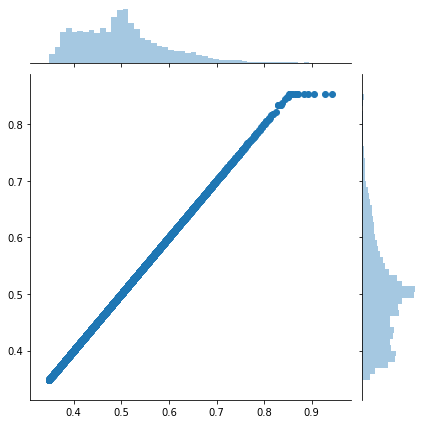

In [16]:
sns.jointplot(treated, matched['p_logit'].values);

### Two sample T test

Returnはt-stats, p-value, df

In [17]:
ttest_ind(treated_df['spend'], matched['spend'])

(4.268034538182298, 1.980842831468609e-05, 20592.0)

In [18]:
ATT_test = CompareMeans(DescrStatsW(treated_df['spend']), 
                        DescrStatsW(matched['spend']))
ATT_test.ttest_ind()
ATT_test.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.9194,0.215,4.268,0.000,0.497,1.342


## 2. IPWを用いた推定

$$
\begin{aligned}
\hat Y_1 &= \left.\sum^N_{i = 1} \frac{D_iY_i}{\hat P(X_i)}\middle/\frac{D_i}{\hat P(X_i)}\right.\\
\hat Y_0 &= \left. \sum^N_{i = 1} \frac{(1 - D_i)Y_i}{1 - \hat P(X_i)}\middle/\frac{1 - D_i}{1 -\hat P(X_i)}\right.\
\end{aligned}
$$

### Intuition

仮に$\hat P(X_i)$と$ Y_1 $に正の相関があるとすると、$ Y_1 $ が小さいほど$D_i=1$のデータに含まれないことになってしまいバイアスが発生する。IPWはtreatment,controlに含まれる確率をpropensity scoreで調整し、treatment, controlのpropensity scoreの分布を等しくさせてからtreatment effectを推定する方法と解釈できる。

分母はweightの合計が1になるようにするため

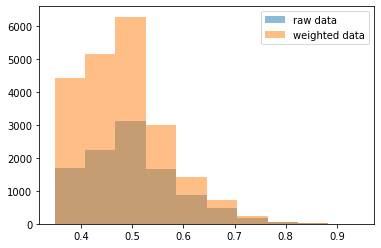

In [19]:
wht = 1/treated
plt.hist(treated, alpha = 0.5, label = 'raw data')
plt.hist(treated, weights = wht, alpha = 0.5, label = 'weighted data')
plt.legend()

### IPWとregression

textでは`weightIt`を用いてweightの算出、それを`lm`の引数に代入して計算している。

#### `weightIt`

- このライブラリで計算されるweightはtreatment statusに応じて`1/p`, `1/(1-p)`となっている
- IPWとは厳密には一致しないので注意

### weightの計算と分布

In [20]:
treated_df['weight'] = 1/treated_df['p_logit']/np.sum(1/treated_df['p_logit'])
non_treated_df['weight'] = 1/(1 - non_treated_df['p_logit'])/np.sum(1/(1 - non_treated_df['p_logit']))
treated_df['raw_weight'] = 1/treated_df['p_logit']
non_treated_df['raw_weight'] = 1/(1 - non_treated_df['p_logit'])

In [21]:
reg_df = pd.concat([treated_df, non_treated_df], axis = 0).reset_index(drop = True)
reg_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,p_logit,weight,raw_weight
0,6,2) $100 - $200,148.25,1,0,Urban,0,Phone,Mens E-Mail,0,0,0.0,1,0.448747,0.000105,2.228428
1,3,3) $200 - $350,309.67,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,0.531090,0.000089,1.882920
2,6,2) $100 - $200,111.25,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,0.441503,0.000106,2.264992
3,3,4) $350 - $500,456.24,0,1,Surburban,0,Multichannel,Mens E-Mail,1,0,0.0,1,0.624486,0.000075,1.601316
4,11,3) $200 - $350,262.82,1,0,Surburban,0,Multichannel,Mens E-Mail,0,0,0.0,1,0.479775,0.000098,2.084309


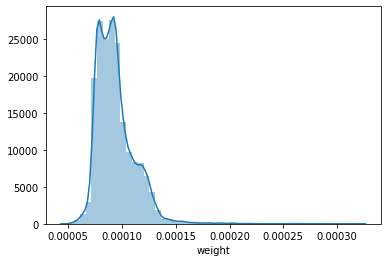

In [22]:
sns.distplot(reg_df['weight']);

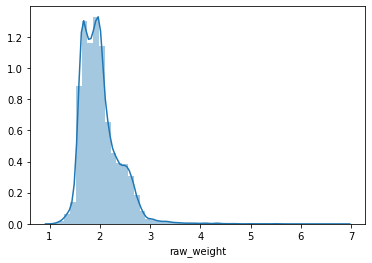

In [23]:
sns.distplot(reg_df['raw_weight']);

### OLSでbiased coefficientsの確認

In [24]:
Y = reg_df['spend']
X = reg_df['treatment']
X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.10
Date:                Thu, 21 May 2020   Prob (F-statistic):           3.56e-05
Time:                        01:38:41   Log-Likelihood:                -89278.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21304   BIC:                         1.786e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6604      0.152      4.336      0.000       0.362       0.959
treatment      0.9060      0.219      4.135      0.000       0.477       1.335
==============================================================================
Omnibus:                    47131.052   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        224258840.767
Skew:                          20.698   Prob(JB):                         0.00
Kurtosis:                     503.900   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
results = sm.WLS.from_formula("spend~treatment", weights=reg_df['weight'],data=reg_df).fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.71
Date:                Thu, 21 May 2020   Prob (F-statistic):           0.000213
Time:                        01:38:41   Log-Likelihood:                -89321.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21304   BIC:                         1.787e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6959      0.154      4.522      0.000       0.394       0.997
treatment      0.8059      0.218      3.703      0.000       0.379       1.232
==============================================================================
Omnibus:                    47047.351   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        220499974.154
Skew:                          20.616   Prob(JB):                         0.00
Kurtosis:                     499.670   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 自作関数IPWでATEを推定

In [26]:
psmatch.get_ate_weight(reg_df, p = reg_df['p_logit'], outcome = 'spend',
                       treat = 'treatment' )

0.8059424511683999

### weightItとの整合性検証

In [27]:
from rpy2.robjects import r, pandas2ri, globalenv
from rpy2.robjects.packages import importr

In [28]:
pandas2ri.activate()
weightit = importr('WeightIt')
r_biased_df = pandas2ri.py2rpy(biased_df.reset_index(drop = True))
globalenv['r_biased_df'] = r_biased_df
r('set.seed(42)')
## 重みの推定
weighting = r("""weighting <- weightit(
                                treatment ~ recency + history + channel,
                                data = r_biased_df,method = "ps",
                                estimand = "ATE")
                                """)

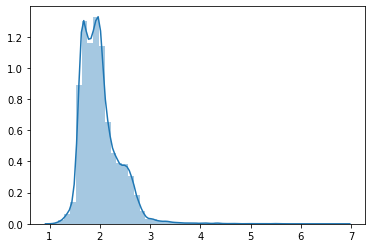

In [29]:
sns.distplot(weighting[0])

In [30]:
results = sm.WLS.from_formula("spend~treatment", weights=weighting[0],
                              data=biased_df.reset_index(drop = True)
                             ).fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.73
Date:                   木, 21  5 2020   Prob (F-statistic):           0.000212
Time:                        01:38:44   Log-Likelihood:                -89307.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21304   BIC:                         1.786e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6959      0.154      4.531      0.000       0.395       0.997
treatment      0.8059      0.217      3.705      0.000       0.380       1.232
==============================================================================
Omnibus:                    47042.968   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        220316097.212
Skew:                          20.612   Prob(JB):                         0.00
Kurtosis:                     499.462   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

standard errorの差はIPWと異なるweightを使用しているため。

## 3. 良い傾向スコアとは

良い傾向スコアとは

- 推定された確率値の順序が正しいか
- covariateのバランスが取れているか

で判断する（後者の方が重要とされている）。

covariateのバランスはnormalized differenceがよく用いられる（0.25を超えるか否かがrule of thumb）

$$
\text{Normalized Difference}_j = \frac{|\bar x_{treated, j} - \bar x_{control, j}|}{(s_{treated, j}^2 + s_{control, j}^2)^{1/2}}
$$

In [31]:
def compute_normed_diff(df, feature, round_digits = 5):
    snd = []
    for i in feature:
        tmp_df = df[i].values
        neg_mean = tmp_df[0, 0]
        neg_std = tmp_df[0, 1]
        pos_mean = tmp_df[1, 0]
        pos_std = tmp_df[1, 1]
        smd = (pos_mean - neg_mean) / np.sqrt((pos_std+ neg_std) / 2)
        smd = round(abs(smd), round_digits)
        snd.append(smd)

    return pd.DataFrame({'features': feature, 'snd': snd})

### unadjusted normalized difference

In [32]:
dummy = sm.tools.categorical(biased_df, col='channel', drop=True)
tmp_df = pd.concat([biased_df, dummy], axis = 1)

In [33]:
colnames = list(tmp_df.columns)
features = []
var_type = tmp_df.dtypes
for i in ['treatment', 'spend']:
    colnames.remove(i)
for i in colnames:
    if var_type[i] in ('int64', 'float64'):
        features.append(i)
normed_diff = tmp_df.groupby(['treatment']).agg([np.mean, 'var'])
unadjusted_diff = compute_normed_diff(normed_diff, feature = features)

### adjusted normalized difference

In [34]:
wtavg = lambda x: np.average(x.loc[:,features], weights = x.weight, axis = 0)
dummy = sm.tools.categorical(reg_df, col='channel', drop=True)
reg_df = pd.concat([reg_df, dummy], axis = 1)
tmp_df = reg_df.loc[:, features + ['treatment', 'weight']]
tmp_df.head()
weighted_mean = tmp_df.groupby(['treatment']).apply(wtavg)
weighted_var = tmp_df.groupby(['treatment']).apply(np.var)

snd = []
for i, j in enumerate(features):
    mean_dif = abs(weighted_mean[0][i] - weighted_mean[1][i])
    denominator = np.sqrt(np.sum(weighted_var[j]))
    smd = mean_dif/denominator
    snd.append(smd)
    
adjusted_diff = pd.DataFrame({'features': features, 'snd': snd})

In [35]:
cobalt_df = adjusted_diff.merge(unadjusted_diff, on ='features', suffixes = ["_adjusted", "_raw"])
cobalt_df

,features,snd_adjusted,snd_raw
0,recency,0.004193,0.24586
1,history,0.011656,0.27647
2,mens,0.000758,0.03724
3,womens,0.001163,0.03590
4,newbie,0.038947,0.00915
5,visit,0.159138,0.25398
6,conversion,0.044462,0.07605
7,p_logit,0.007549,0.35048
8,Multichannel,0.007016,0.00988
9,Phone,0.001895,0.01489


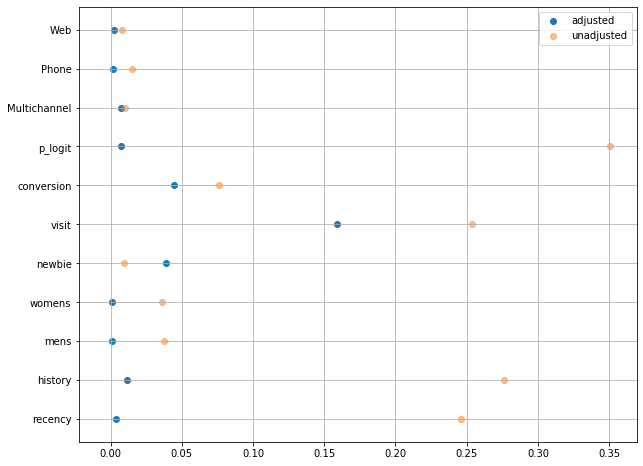

In [36]:
plt.figure(figsize = (10, 8))
plt.grid(True)
plt.scatter(x = cobalt_df['snd_adjusted'], y = cobalt_df['features'],
           label = 'adjusted', alpha = 1)
plt.scatter(x = cobalt_df['snd_raw'], y = cobalt_df['features'],
           label = 'unadjusted', alpha = 0.5)
plt.legend();

### Tips

- 機械学習が導入されて意思決定を自動化している場所では入手できるデータに介入の割り振り確率、傾向スコアそのものがログデータとして残っている場合がある
- 仮に残っていなくてもDを決定する仕組みの仕様が残されている場合もあり、効果検証する土壌がある可能性がある

## 4. Simulation：買う確率が高い人にメールマーケティングをしてしまっているケース
### 方針
1. dataを疑似的に過去のデータ（train, non-treatedのみ）, 未来のデータ(test)に分けるとみなす
2. trainを用いてcovariateに応じたconversion modelをlogitで作成
3. 作成したモデルに基づいて、testに含まれる各主体に対してconversion rateを推定
4. (3)で推定された確率をtest内部でパーセントランクに変換
5. パーセントランクに基づき介入を割り当てる
6. 配信ログを作成
7. RCT, naive estimator, IPWの比較をする

In [37]:
random_seed = 42
np.random.seed(random_seed)

In [38]:
train_df = male_df.sample(frac = 0.5, random_state = random_seed)
test_index = set(male_df.index) - set(train_df.index)
test_df = male_df.loc[test_index, :]

#### trainをtreatment == 0に限定する

In [39]:
train_df = train_df.query("treatment == 0")

#### trainを用いてlogitモデル構築

In [40]:
logit_formula = 'conversion ~ recency + history_segment + channel + zip_code'
logit_res = smf.logit(formula=logit_formula, data=train_df).fit()

Optimization terminated successfully.
         Current function value: 0.038507
         Iterations 10


#### test_dfのconversion rateを予測

In [41]:
test_df['pscore'] = logit_res.predict(test_df)

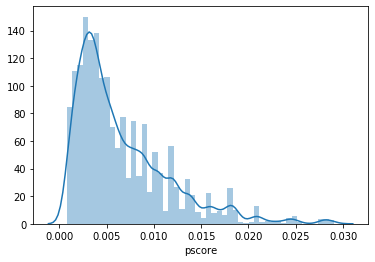

In [42]:
sns.distplot(test_df['pscore'])

#### パーセントランクの計算

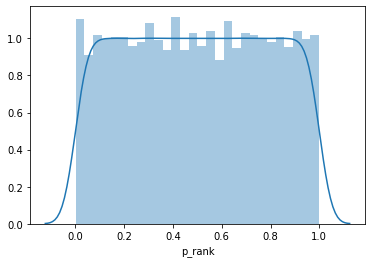

In [43]:
test_df['p_rank'] = test_df['pscore'].rank(pct=True)
sns.distplot(test_df['p_rank'])

#### パーセントランクに基づき介入を割り当てる

- `pandas.DataFrame.apply`ではなく`numpy.array`の方が速い

In [44]:
#%%timeit 
#prob = test_df['p_rank'].values
#np.random.binomial(n = 1, p = prob)

In [45]:
#%%timeit
#test_df['p_rank'].apply(lambda x: np.random.binomial(n=1, p=x))

In [46]:
prob = test_df['p_rank'].values
assign = np.random.binomial(n = 1, p = prob)

In [47]:
test_df['assign'] = assign

#### 配信ログを作成

In [48]:
log_df = test_df.query("(treatment == 1 & assign == 1) or (treatment == 0 & assign == 0)")
log_df = log_df.reset_index(drop = True)

In [49]:
log_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore,p_rank,assign
0,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,0.008908,0.743488,0
1,5,"6) $750 - $1,000",828.42,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,1,0.004402,0.431971,1
2,9,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0,0,0.002860,0.225466,0
3,6,2) $100 - $200,139.87,0,1,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0.002618,0.197635,1
4,6,2) $100 - $200,128.01,0,1,Urban,0,Web,Mens E-Mail,0,0,0.0,1,0.002537,0.186136,1


#### RCT, IPW, naive estimatorの比較

In [50]:
### IPWのためのweight作成
TREAT = (1/log_df.query('assign == 1')['p_rank']).sum()
CONTROL = (1/(1 - log_df.query('assign == 1')['p_rank'])).sum()
log_df['weight'] = log_df.apply(lambda x : 1/x['p_rank']/TREAT if x['assign'] == 1 
                                else (1/(1 - x['p_rank']))/CONTROL
                                , axis = 1)

In [51]:
results = []
for i in [test_df, log_df]:
    y, X = dmatrices('spend~treatment',
                         data = i,
                         return_type = 'dataframe')
    res = sm.OLS(y, X).fit(cov_type = 'HC0')
    results.append(res)

res = sm.WLS.from_formula("spend~treatment", weights=log_df['weight'],
                              data=log_df).fit() 
results.append(res)

In [52]:
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'treatment']
results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=['RCT', 'naive', 'IPW'],
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('EDUCATIONAL OUTCOMES AND VOUCHER STATUS')
print(results_table)

 EDUCATIONAL OUTCOMES AND VOUCHER STATUS
                   RCT     naive     IPW  
------------------------------------------
Intercept        0.578*** 0.466*** 0.621  
                 (0.108)  (0.118)  (0.422)
treatment        0.687*** 0.830*** 0.747* 
                 (0.194)  (0.251)  (0.449)
R-squared        0.001    0.001    0.000  
                 0.001    0.001    0.000  
Pseudo R-squared                          
No. observations 21307    10709    10709  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


biasは軽減されていることがわかる

## 5. Selecting Target with Causal Tree

- mail marketing targetをspend uplift最大化するような形で設定する
- causal treeを用いてupliftfが高組み込めそうなindividualにmarketingを実施、その時のrevenue impactをsimulationする
- see [policy targeting](https://voxeu.org/article/effective-policy-targeting-machine-learning)

### Key Concept

- policyのeffectivenessはtargetをどのように絞るかによって実現される
- returnが最も大きいグループにpolicyを打ち出すべき = 介入効果があるグループのみ介入する

### Method

- Honest Causal Tree Learning

### 方針

1. causaltreeでuplift効果を予測
2. Select treatment target
3. revenue simulation

### REMARKS

一般的にはUpliftModeling Scoreは以下のように定義される

$$
\text{UpliftModeling Score} = \frac{\text{treated時のスコア}}{\text{non-treated時のスコア}}
$$


### causal tree estimate

In [53]:
dummy_channel = sm.tools.categorical(male_df, col='channel', drop=True)
dummy_zipcode = sm.tools.categorical(male_df, col='zip_code', drop=True)
causal_df = pd.concat([male_df, dummy_channel, dummy_zipcode], axis = 1)

In [54]:
causal_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,Multichannel,Phone,Web,Rural,Surburban,Urban
0,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,0,0,1,1,0,0
1,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0,0,1,1,0,0
2,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,0,1,0,1,0,0
3,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,0,0,1,0,0,1
4,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,1,0,0,1,0,0


### pre-processing

In [55]:
causal_df.dtypes

recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
segment             object
visit                int64
conversion           int64
spend              float64
treatment            int64
Multichannel         uint8
Phone                uint8
Web                  uint8
Rural                uint8
Surburban            uint8
Urban                uint8
dtype: object

In [56]:
features = []
for i in causal_df.columns:
    if causal_df.dtypes[i] in ('int64', 'float64', 'uint8'):
        features.append(i)

In [57]:
reg_df = causal_df.loc[:, features]
reg_df.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,treatment,Multichannel,Phone,Web,Rural,Surburban,Urban
0,6,329.08,1,1,1,0,0,0.0,0,0,0,1,1,0,0
1,9,675.83,1,0,1,0,0,0.0,1,0,0,1,1,0,0
2,9,675.07,1,1,1,0,0,0.0,1,0,1,0,1,0,0
3,2,101.64,0,1,0,1,0,0.0,1,0,0,1,0,0,1
4,4,241.42,0,1,1,0,0,0.0,0,1,0,0,1,0,0


#### 過去と未来のデータを分ける

In [58]:
past_df = reg_df.sample(frac = 0.9, random_state = 42)
is_future = set(reg_df.index) - set(past_df.index)
simulation_df = reg_df.loc[is_future, :].reset_index(drop = True)
past_df = past_df.reset_index(drop = True)

#### logitでconversion rateを予測

In [59]:
logit_formula = 'conversion ~ recency + history + newbie + Phone + Web + Rural + Surburban'
logit_res = smf.logit(formula=logit_formula, data=past_df.query('treatment == 0')).fit()
past_df['pscore'] = logit_res.predict(past_df)

Optimization terminated successfully.
         Current function value: 0.034460
         Iterations 10


### CATE estimation

In [60]:
y = past_df['conversion'].values
Z = past_df['pscore']
X = past_df.drop(['conversion', 'treatment', 'spend', 'visit', 'pscore'], axis = 1).values
treatment = past_df['treatment'].values

In [61]:
x_train, x_test, y_train, y_test, Z_train, Z_test, treat_train,treat_test = train_test_split(X, 
                                                                             y, 
                                                                             Z,
                                                                             treatment,
                                                                             test_size=0.2, 
                                                                             random_state=42)

In [62]:
## 自作関数
#cth = hct.CausalTree(honest=True)
#cth.fit(x_train, y_train, treat_train)
#cth_predict = cth.predict(x_test)
#cth.plot_tree(training_data=x_train)

In [63]:
cth = CausalTree(honest=True)
cth.fit(x_train, y_train, treat_train)
cth_predict = cth.predict(x_test)
#sns.distplot(cth_predict)

In [64]:
# plot
cth.plot_tree(training_data=x_train)

#### spend uplift精度検証のためのデータ整形

In [65]:
check_df = pd.DataFrame(np.stack([y_test, treat_test,Z_test, cth_predict], axis = 1),
                        columns = ['spend', 'treatment','pscore','predict'])
check_df['conversion'] = list(map(lambda x: 1 if x > 0.0 else 0, check_df['spend'].values))
check_df.head()

,spend,treatment,pscore,predict,conversion
0,0.0,1.0,0.004041,0.007821,0
1,0.0,1.0,0.002149,0.007821,0
2,0.0,1.0,0.004878,0.007821,0
3,0.0,1.0,0.005387,0.007821,0
4,0.0,0.0,0.003636,0.007821,0


In [66]:
check_df.groupby('treatment').agg('mean')

,spend,pscore,predict,conversion
treatment,,,,
0.0,0.005490,0.005824,0.007429,0.005490
1.0,0.013001,0.005775,0.007631,0.013001


In [67]:
check_df.describe()

,spend,treatment,pscore,predict,conversion
count,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000
mean,0.009256,0.501369,0.005800,0.007530,0.009256
std,0.095766,0.500031,0.004565,0.007509,0.095766
min,0.000000,0.000000,0.000800,-0.200000,0.000000
25%,0.000000,0.000000,0.002729,0.007821,0.000000
50%,0.000000,1.000000,0.004477,0.007821,0.000000
75%,0.000000,1.000000,0.007955,0.007821,0.000000
max,1.000000,1.000000,0.126035,0.007821,1.000000


#### パーセンタイルの計算

In [68]:
check_df['effect_rank'] = check_df['predict'].rank(pct=True)
check_df['ps_rank'] = check_df['pscore'].rank(pct=True)

In [69]:
check_df.head()

,spend,treatment,pscore,predict,conversion,effect_rank,ps_rank
0,0.0,1.0,0.004041,0.007821,0,0.502021,0.442054
1,0.0,1.0,0.002149,0.007821,0,0.502021,0.188502
2,0.0,1.0,0.004878,0.007821,0,0.502021,0.542954
3,0.0,1.0,0.005387,0.007821,0,0.502021,0.590014
4,0.0,0.0,0.003636,0.007821,0,0.502021,0.383392


### Uplift score percentile visualization

In [70]:
def percentile_classfication(x):
    if x < 0.1:
        return '0 ~ 10%'
    elif x < 0.2:
        return '10 ~ 20%'
    elif x < 0.3:
        return '20 ~ 30%'
    elif x < 0.4:
        return '30 ~ 40%'
    elif x < 0.5:
        return '40 ~ 50%'
    elif x < 0.6:
        return '50 ~ 60%'
    elif x < 0.7:
        return '60 ~ 70%'
    elif x < 0.8:
        return '70 ~ 80%'
    elif x < 0.9:
        return '80 ~ 90%'
    else:
        return '90~100%'
classify = np.vectorize(percentile_classfication)

In [71]:
check_df['effect_group'] = classify(check_df['effect_rank'].values)
check_df['ps_group'] = classify(check_df['ps_rank'].values)

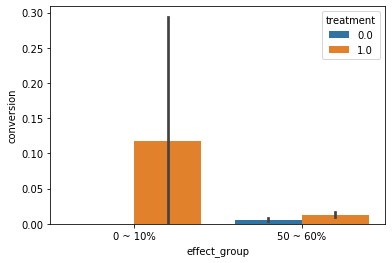

In [72]:
sns.barplot(x = 'effect_group', y = 'conversion',
            hue = 'treatment',
            estimator = np.mean,
            data = check_df.sort_values('predict'))

In [73]:
#fig, ax = plt.subplots(figsize = (10, 8))
#sns.barplot(x = 'ps_group', y = 'spend',
#            hue = 'treatment',
#            estimator = np.mean,
#            data = check_df.sort_values('ps_rank'),
#           ax = ax)

理想型とはいかないので、ここで打ち切り。

- causal treeのライブラリが信用できるかそもそも疑問（Susan AtheyのRパッケージを使用する方が良い）
- uplift modelingは別途取り扱う

### Tips

- Uplift Modelingの評価方法としてAUUCがある
- Area Under the Uplift Curveの略

#### AUUC手順

1. スコアを高い順にsort
2. スコア順にtreatmentによるliftを計算
3. randomに介入を行ったときをベースラインとする
4. liftとベースラインに囲まれた面積を算出


## 6. Lalondeデータセット分析

この分析はchapter 2の補足で取り扱ったので、テキストのRコード再現と一部加筆に集中する。

### Lalondeデータセットとは

- NSWのRCTデータセットとCPSのデータセットを用いいて、職業訓練をtreatmentとしたとき、treated sampleをNSWより、non-treatedをNSWではなくCPSからサンプルを抽出。
- EconometricsのMethodで疑似観察データからでもATE, ATTが推定できるかを確かめのが目的

### Read Data

In [74]:
cps1_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
cps3_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
nswdw_data = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

In [75]:
nswdw_data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


### 前処理

In [76]:
is_treat = nswdw_data['treat'] == 1
cps1 = pd.concat([nswdw_data.loc[is_treat], cps1_data], axis  = 0, ignore_index = True)
cps3 = pd.concat([nswdw_data.loc[is_treat], cps3_data], axis  = 0, ignore_index = True)

### RCT dataを用いてATE算出

In [77]:
f1 = 're78 ~ treat'
f2 = 're78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
regressor_order = ['Intercept', 'treat', 're74', 're75', 'age', 'education', 'black',
                   'hispanic', 'nodegree', 'married']
formula = [f1, f2]
results = []
for f in formula:
    y, X = dmatrices(f, data = nswdw_data, return_type = 'dataframe')
    res = sm.OLS(y, X).fit(cov_type = 'HC0')
    results.append(res)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            regressor_order = regressor_order,
                            model_names = ['Bivariate', 'Multivariate'],
                            info_dict=info_dict)
results_table.add_title('RCT BASE LINE TREATMENT EFFECT') 
print(results_table)
    

     RCT BASE LINE TREATMENT EFFECT
                  Bivariate  Multivariate
-----------------------------------------
Intercept        4554.801*** 785.061     
                 (339.438)   (3260.033)  
treat            1794.342*** 1676.343**  
                 (669.315)   (669.087)   
re74                         0.082       
                             (0.106)     
re75                         0.053       
                             (0.123)     
age                          55.317      
                             (40.819)    
education                    395.734**   
                             (195.113)   
black                        -2159.522** 
                             (1000.380)  
hispanic                     164.033     
                             (1351.463)  
nodegree                     -70.681     
                             (1015.123)  
married                      -138.725    
                             (863.581)   
R-squared        0.016       0.035      

### CPS1 datasetでの分析

In [78]:
f1 = 're78 ~ treat'
f2 = 're78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
regressor_order = ['Intercept', 'treat', 're74', 're75', 'age', 'education', 'black',
                   'hispanic', 'nodegree', 'married']
formula = [f1, f2]
results = []
for f in formula:
    y, X = dmatrices(f, data = cps1, return_type = 'dataframe')
    res = sm.OLS(y, X).fit(cov_type = 'HC0')
    results.append(res)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            regressor_order = regressor_order,
                            model_names = ['Bivariate', 'Multivariate'],
                            info_dict=info_dict)
results_table.add_title('CPS1 dataset treatment effect estimation') 
print(results_table)
    

 CPS1 dataset treatment effect estimation
                  Bivariate   Multivariate
------------------------------------------
Intercept        14846.660*** 5735.731*** 
                 (76.286)     (443.621)   
treat            -8497.516*** 699.132     
                 (581.880)    (616.463)   
re74                          0.289***    
                              (0.015)     
re75                          0.471***    
                              (0.015)     
age                           -101.855*** 
                              (5.713)     
education                     160.186***  
                              (28.738)    
black                         -836.947*** 
                              (196.775)   
hispanic                      -218.318    
                              (217.986)   
nodegree                      372.238**   
                              (174.781)   
married                       73.076      
                              (144.365)   
R-squared   

treatment effectがRCTと異なるのは、treatment, controlのcovariateの分布が大きく異なることに起因すると考えられる

- normalized differenceが0.25を超えているかの確認

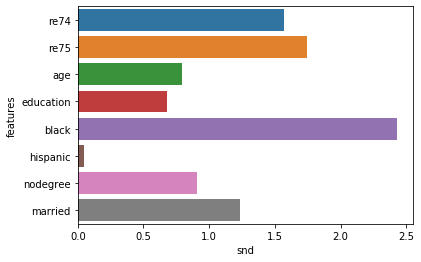

In [79]:
features = ['re74', 're75', 'age', 'education', 'black','hispanic', 'nodegree', 'married']
normed_diff = cps1.groupby(['treat']).agg([np.mean, 'var'])
snd = compute_normed_diff(normed_diff, feature = features)
sns.barplot(x = 'snd', y = 'features', data = snd);

### CPS3 datasetでの分析

- CPSのsampleは1976年時点で雇用されていないサンプル

In [80]:
f1 = 're78 ~ treat'
f2 = 're78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
regressor_order = ['Intercept', 'treat', 're74', 're75', 'age', 'education', 'black',
                   'hispanic', 'nodegree', 'married']
formula = [f1, f2]
results = []
for f in formula:
    y, X = dmatrices(f, data = cps3, return_type = 'dataframe')
    res = sm.OLS(y, X).fit(cov_type = 'HC0')
    results.append(res)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            regressor_order = regressor_order,
                            model_names = ['Bivariate', 'Multivariate'],
                            info_dict=info_dict)
results_table.add_title('CPS1 dataset treatment effect estimation') 
print(results_table)
    

CPS1 dataset treatment effect estimation
                  Bivariate  Multivariate
-----------------------------------------
Intercept        6984.170*** 66.515      
                 (351.755)   (2509.331)  
treat            -635.026    1548.244**  
                 (675.645)   (734.521)   
re74                         0.296***    
                             (0.071)     
re75                         0.232*      
                             (0.118)     
age                          12.978      
                             (31.445)    
education                    403.941**   
                             (159.083)   
black                        -1240.644*  
                             (690.077)   
hispanic                     498.897     
                             (945.065)   
nodegree                     259.817     
                             (884.494)   
married                      406.621     
                             (653.165)   
R-squared        -0.000      0.135 

### 傾向スコア（Nearest Matching）を用いた効果の推定

In [81]:
cps1['I_re74'] = cps1['re74'].values **2
cps1['I_re75'] = cps1['re75'].values **2

In [82]:
logit_formula = 'treat ~ re74 + re75 + age + education + black + hispanic + nodegree + married + I_re74 + I_re75'
logit_res = smf.logit(formula=logit_formula, data=cps1).fit()

Optimization terminated successfully.
         Current function value: 0.030601
         Iterations 12


In [83]:
cps1['pscore'] = logit_res.predict()
TREAT = (1/cps1.query('treat == 1')['pscore']).sum()
CONTROL = (1/(1 - cps1.query('treat == 0')['pscore'])).sum()
cps1['weight'] = cps1.apply(lambda x : 1/x['pscore']/TREAT if x['treat'] == 1 
                                else (1/(1 - x['pscore']))/CONTROL
                                , axis = 1)

#### Find the pair

In [84]:
treated_df = cps1.query('treat == 1').reset_index(drop = True)
control_df = cps1.query('treat == 0').reset_index(drop = True)

treated = treated_df['pscore'].values
non_treated = control_df['pscore'].values


### learning training data　ここではcontrol
nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(non_treated.reshape(-1, 1))
### Find index
distances, indices = nbrs.kneighbors(treated.reshape(-1, 1))

In [85]:
indices = indices.reshape(indices.shape[0])
matched = control_df.loc[indices, :]

#### Normalized Difference

In [86]:
tmp_df = pd.concat([treated_df, matched], axis = 0)
colnames = ['re74', 're75', 'age', 'education', 'black','hispanic',
            'nodegree', 'married', 'I_re74', 'I_re75']
normed_diff = tmp_df.groupby(['treat'])[colnames].agg([np.mean, 'var'])
unadjusted_diff = compute_normed_diff(normed_diff, feature = colnames)

wtavg = lambda x: np.average(x.loc[:,colnames], weights = x.weight, axis = 0)
tmp_df = tmp_df.loc[:, colnames + ['treat', 'weight']]
tmp_df.head()
weighted_mean = tmp_df.groupby(['treat']).apply(wtavg)
weighted_var = tmp_df.groupby(['treat']).apply(np.var)

snd = []
for i, j in enumerate(colnames):
    mean_dif = abs(weighted_mean[0][i] - weighted_mean[1][i])
    denominator = np.sqrt(np.sum(weighted_var[j]))
    smd = mean_dif/denominator
    snd.append(smd)
    
adjusted_diff = pd.DataFrame({'features': colnames, 'snd': snd})
cobalt_df = adjusted_diff.merge(unadjusted_diff, on ='features', suffixes = ["_adjusted", "_raw"])
cobalt_df

,features,snd_adjusted,snd_raw
0,re74,0.809762,0.13261
1,re75,1.308075,0.07118
2,age,0.250903,0.16804
3,education,0.309505,0.10196
4,black,1.248636,0.01473
5,hispanic,0.172530,0.04769
6,nodegree,0.474270,0.19468
7,married,0.700661,0.11566
8,I_re74,0.399575,0.09748
9,I_re75,1.395658,0.02722


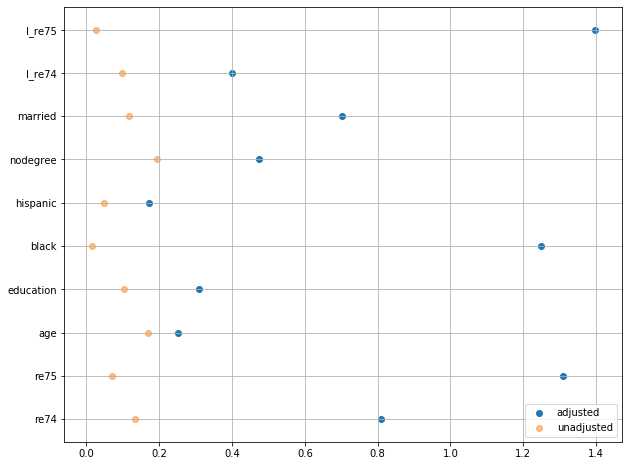

In [87]:
plt.figure(figsize = (10, 8))
plt.grid(True)
plt.scatter(x = cobalt_df['snd_adjusted'], y = cobalt_df['features'],
           label = 'adjusted', alpha = 1)
plt.scatter(x = cobalt_df['snd_raw'], y = cobalt_df['features'],
           label = 'unadjusted', alpha = 0.5)
plt.legend();

#### Estimation

In [88]:
ATT_test = CompareMeans(DescrStatsW(treated_df['re78']), 
                        DescrStatsW(matched['re78']))
ATT_test.ttest_ind()
ATT_test.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,1713.3395,718.237,2.385,0.018,300.976,3125.703


### IPWで推定

### normalized difference

In [89]:
normed_diff = cps1.groupby(['treat'])[colnames].agg([np.mean, 'var'])
unadjusted_diff = compute_normed_diff(normed_diff, feature = colnames)

wtavg = lambda x: np.average(x.loc[:,colnames], weights = x.weight, axis = 0)
tmp_df = cps1.loc[:, colnames + ['treat', 'weight']]
tmp_df.head()
weighted_mean = tmp_df.groupby(['treat']).apply(wtavg)
weighted_var = tmp_df.groupby(['treat']).apply(np.var)

snd = []
for i, j in enumerate(colnames):
    mean_dif = abs(weighted_mean[0][i] - weighted_mean[1][i])
    denominator = np.sqrt(np.sum(weighted_var[j]))
    smd = mean_dif/denominator
    snd.append(smd)
    
adjusted_diff = pd.DataFrame({'features': colnames, 'snd': snd})
cobalt_df = adjusted_diff.merge(unadjusted_diff, on ='features', suffixes = ["_adjusted", "_raw"])
cobalt_df

,features,snd_adjusted,snd_raw
0,re74,0.710639,1.56899
1,re75,0.681175,1.74643
2,age,0.496807,0.79618
3,education,0.159644,0.67850
4,black,0.356425,2.42775
5,hispanic,0.051692,0.05070
6,nodegree,0.092962,0.90381
7,married,0.374634,1.23265
8,I_re74,0.764474,1.29337
9,I_re75,0.618984,1.45018


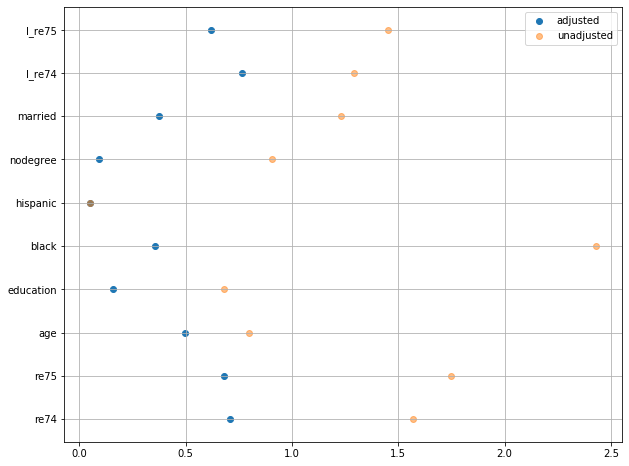

In [90]:
plt.figure(figsize = (10, 8))
plt.grid(True)
plt.scatter(x = cobalt_df['snd_adjusted'], y = cobalt_df['features'],
           label = 'adjusted', alpha = 1)
plt.scatter(x = cobalt_df['snd_raw'], y = cobalt_df['features'],
           label = 'unadjusted', alpha = 0.5)
plt.legend();

In [91]:
res = sm.WLS.from_formula("re78~treat", weights=cps1['weight'], data = cps1).fit(cov_type = 'HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.192
Model:                            WLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     19.64
Date:                   木, 21  5 2020   Prob (F-statistic):           9.42e-06
Time:                        01:40:10   Log-Likelihood:            -1.7329e+05
No. Observations:               16177   AIC:                         3.466e+05
Df Residuals:                   16175   BIC:                         3.466e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.474e+04     76.953    191.487      0.000    1.46e+04    1.49e+04
treat      -7626.8058   1721.008     -4.432      0.000    -1.1e+04   -4253.693
==============================================================================
Omnibus:                     6665.125   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9338288.650
Skew:                          -0.227   Prob(JB):                         0.00
Kurtosis:                     120.703   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### REMARKS

- Normalized differenceが0.25を超える場合、IPWの使用は控えるべき